In [14]:
# Multi-Strategy Backtest: LSV, HLSV, and LSLV

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Trading cost assumptions
def trading_costs(price, qty, fee_rate=0.0015):
    """Calculate total cost = price*qty*fee_rate."""
    return price * qty * fee_rate

# Load data for VIXY, SVXY, and SPY
start_date = '2011-10-11'
end_date = '2024-12-31'
tickers = ['VIXY', 'SVXY', 'SPY']
raw = yf.download(tickers, start=start_date, end=end_date)[['Open','Close']]
raw.columns = [f'{p.lower()}_{t.lower()}' for p,t in raw.columns]

# Load VIX spot
vix = yf.download('^VIX', start=start_date, end=end_date)
vix.columns = [f"{p.lower()}_{t.lower().lstrip('^')}" for p, t in vix.columns]
vix = vix[['open_vix']]

# Load front-month VIX futures (assume pre-downloaded CSV)
fut = pd.read_csv('S&P 500 VIX Futures Historical All Data.csv', parse_dates=['Date'], index_col='Date')
fut = fut.sort_index()
fut = fut[['Open']].loc[:end_date].rename(columns={'Open':'open_vix_futures'})

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
vix.columns

Index(['open_vix'], dtype='object')

In [16]:
df = raw.join(vix, how='left').join(fut, how='left')
df = df.dropna(subset=['open_vix','open_vix_futures'])

def compute_basis(data):
    data['basis'] = data['open_vix_futures'] / data['open_vix'] - 1
    return data
df = compute_basis(df)

df

,open_spy,open_svxy,open_vixy,close_spy,close_svxy,close_vixy,open_vix,open_vix_futures,basis
Date,,,,,,,,,
2011-10-11,93.061332,12.062500,809440.000000,93.711121,12.315000,790160.000000,33.950001,34.67,0.021208
2011-10-12,94.415716,12.790000,761280.000000,94.533150,13.172500,736800.000000,31.570000,34.47,0.091859
2011-10-13,93.977312,13.000000,745600.000000,94.345268,13.067500,735360.000000,31.990000,32.80,0.025320
2011-10-14,95.441308,13.847500,703440.000000,95.958008,13.937500,692560.000000,29.070000,31.13,0.070863
2011-10-17,95.503915,13.725000,696000.000000,94.126045,12.405000,765760.000000,30.350000,29.42,-0.030643
...,...,...,...,...,...,...,...,...,...
2024-12-23,589.117842,49.529999,46.369999,592.906433,50.660000,44.060001,18.090000,18.20,0.006081
2024-12-24,594.272307,51.000000,43.259998,599.496582,52.029999,41.560001,16.969999,17.00,0.001768
2024-12-26,597.701991,51.680000,42.220001,599.536499,51.970001,41.810001,14.990000,16.05,0.070714


In [17]:
df.to_csv('data.csv')

In [84]:
def backtest_strategy(df, signals, capital=100000, fee_rate=0.0015):
    """
    Unified backtest engine.
    Ensures cash never goes negative by computing order size net of transaction costs.
    signals: dict of asset -> Series of 'buy'/'sell' signals.
    """
    dates = df.index
    cash = capital
    cash_hist = []
    holdings = {asset: [] for asset in signals.keys()}
    asset_vals = []
    port_vals = []
    pos = {asset: 0.0 for asset in signals.keys()}
    trades = []

    for date in dates:
        # get prices for each asset
        price_info = {asset: df.at[date, f'close_{asset.lower()}'] for asset in signals.keys()}
        # process each asset
        for asset, sig in signals.items():
            action = sig.at[date]
            price = price_info[asset]
            if action == 'buy' and pos[asset] == 0:
                # compute maximum affordable quantity including fee
                qty = cash / (price * (1 + fee_rate))
                if qty <= 0:
                    continue
                fee = trading_costs(price, qty, fee_rate)
                cash -= qty * price + fee
                pos[asset] = qty
                trades.append((date, 'BUY', asset, price, qty, fee))
            elif action == 'sell' and pos[asset] > 0:
                qty = pos[asset]
                fee = trading_costs(price, qty, fee_rate)
                cash += qty * price - fee
                trades.append((date, 'SELL', asset, price, qty, fee))
                pos[asset] = 0.0
        # record daily values
        cash_hist.append(max(cash, 0.0))  # ensure non-negative
        total_value = 0.0
        for asset, qty in pos.items():
            holdings[asset].append(qty)
            total_value += qty * price_info[asset]
        asset_vals.append(total_value)
        port_vals.append(cash + total_value)

    result = pd.DataFrame(index=dates)
    result['cash'] = cash_hist
    for asset, hist in holdings.items():
        result[f'hold_{asset.lower()}'] = hist
    result['asset_value'] = asset_vals
    result['portfolio'] = port_vals
    result['returns'] = result['portfolio'].pct_change().fillna(0)
    result['cum_return'] = (1 + result['returns']).cumprod() - 1
    trades_df = pd.DataFrame(trades, columns=['date','action','asset','price','qty','fee']).set_index('date')
    return result, trades_df

In [85]:
# Strategy definitions
def simulate_lsv(df, capital=100000):
    """LSV using unified backtest_engine: long VIXY when basis<0, long SVXY when basis>=0."""
    # Generate signal series for VIXY and SVXY
    sig_vixy = pd.Series(index=df.index, dtype=object)
    sig_svxy = pd.Series(index=df.index, dtype=object)
    # When basis<0: buy VIXY, sell SVXY; when basis>=0: buy SVXY, sell VIXY
    sig_vixy[df['basis'] < 0] = 'buy'
    sig_svxy[df['basis'] < 0] = 'sell'
    sig_vixy[df['basis'] >= 0] = 'sell'
    sig_svxy[df['basis'] >= 0] = 'buy'
    signals = {'VIXY': sig_vixy, 'SVXY': sig_svxy}
    # Run unified backtest
    return backtest_strategy(df, signals, capital)

def simulate_hlsv(df, capital=100000):
    """HLSV using unified backtest_engine: 50% VIX leg (VIXY/SVXY) and 50% SPY hedge."""
    # Generate VIX leg signals based on basis
    sig_vixy = pd.Series(index=df.index, dtype=object)
    sig_svxy = pd.Series(index=df.index, dtype=object)
    # When basis<0: buy VIXY, sell SVXY; when basis>=0: buy SVXY, sell VIXY
    sig_vixy[df['basis'] < 0] = 'buy'
    sig_svxy[df['basis'] < 0] = 'sell'
    sig_vixy[df['basis'] >= 0] = 'sell'
    sig_svxy[df['basis'] >= 0] = 'buy'
    # SPY hedge signals: when basis<0 long SPY; when basis>=0 short SPY
    sig_spy = pd.Series(index=df.index, dtype=object)
    sig_spy[df['basis'] < 0] = 'buy'
    sig_spy[df['basis'] >= 0] = 'sell'
    # Combine into signals dict
    signals = {'VIXY': sig_vixy, 'SVXY': sig_svxy, 'SPY': sig_spy}
    # Run unified backtest
    return backtest_strategy(df, signals, capital)

def simulate_lslv(df, capital=100000, fee_rate=0.0015):
    """LSLV with target-weight rebalancing: long 100% SPY in contango; long 25% VIXY + 75% SPY in backwardation."""
    dates = df.index
    cash = capital
    hold_spy = 0.0
    hold_vixy = 0.0
    cash_hist = []
    spy_hist = []
    vixy_hist = []
    port_vals = []
    trades = []

    for date in dates:
        price_spy = df.at[date, 'close_spy']
        price_vixy = df.at[date, 'close_vixy']
        # current portfolio value
        port_val = cash + hold_spy * price_spy + hold_vixy * price_vixy
        # determine target weights
        if df.at[date, 'basis'] >= 0:
            weights = {'SPY': 1.0, 'VIXY': 0.0}
        else:
            weights = {'SPY': 0.75, 'VIXY': 0.25}
        # compute target units for each
        target_spy = weights['SPY'] * port_val / (price_spy * (1 + fee_rate))
        target_vix = weights['VIXY'] * port_val / (price_vixy * (1 + fee_rate))
        # rebalance SPY
        delta_spy = target_spy - hold_spy
        if abs(delta_spy) > 1e-6:
            fee = trading_costs(price_spy, abs(delta_spy), fee_rate)
            # cost for buy: qty*price + fee; proceeds for sell: qty*price - fee
            if delta_spy > 0:
                cost = delta_spy * price_spy + fee
                cash -= cost
                trades.append((date, 'BUY', 'SPY', price_spy, delta_spy, fee))
            else:
                proceeds = -delta_spy * price_spy - fee
                cash += proceeds
                trades.append((date, 'SELL', 'SPY', price_spy, -delta_spy, fee))
            hold_spy = target_spy
        # rebalance VIXY
        delta_vix = target_vix - hold_vixy
        if abs(delta_vix) > 1e-6:
            fee = trading_costs(price_vixy, abs(delta_vix), fee_rate)
            if delta_vix > 0:
                cost = delta_vix * price_vixy + fee
                cash -= cost
                trades.append((date, 'BUY', 'VIXY', price_vixy, delta_vix, fee))
            else:
                proceeds = -delta_vix * price_vixy - fee
                cash += proceeds
                trades.append((date, 'SELL', 'VIXY', price_vixy, -delta_vix, fee))
            hold_vixy = target_vix
        # record
        cash_hist.append(max(cash, 0.0))
        spy_hist.append(hold_spy)
        vixy_hist.append(hold_vixy)
        port_vals.append(cash + hold_spy * price_spy + hold_vixy * price_vixy)

    df_res = pd.DataFrame({
        'cash': cash_hist,
        'hold_spy': spy_hist,
        'hold_vixy': vixy_hist,
        'portfolio': port_vals
    }, index=dates)
    df_res['returns'] = df_res['portfolio'].pct_change().fillna(0)
    df_res['cum_return'] = (1 + df_res['returns']).cumprod() - 1
    trades_df = pd.DataFrame(trades, columns=['date','action','asset','price','qty','fee']).set_index('date')
    return df_res, trades_df

# Run and visualize
lsv_res, lsv_tr = simulate_lsv(df)
hlsv_res, hlsv_tr = simulate_hlsv(df)
lslv_res, lslv_tr = simulate_lslv(df)

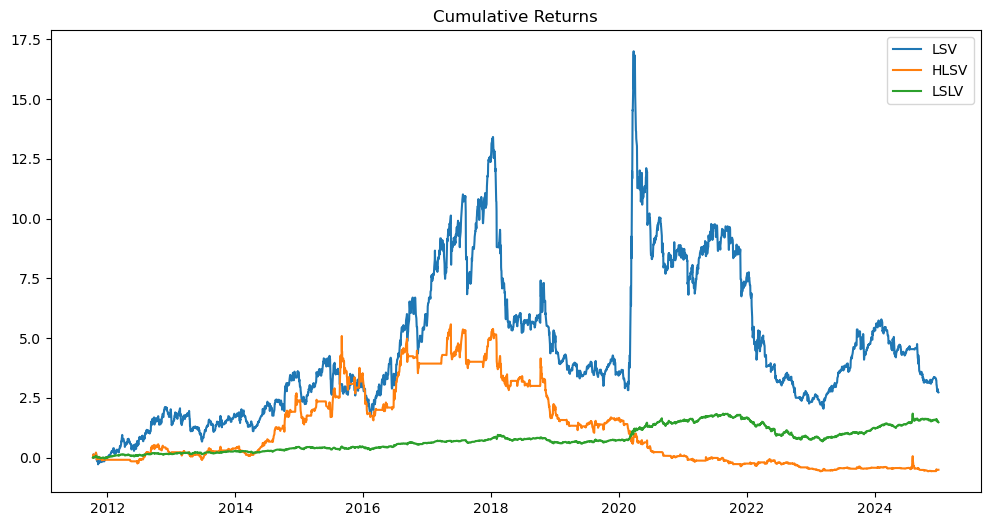

LSV trades: 1045
HLSV trades: 1906
LSLV trades: 4410


In [135]:
plt.figure(figsize=(12,6))
for label, res in [('LSV',lsv_res),('HLSV',hlsv_res),('LSLV',lslv_res)]:
    plt.plot(res.index, res['cum_return'], label=label)
plt.title('Cumulative Returns')
plt.legend(); plt.show()

print('LSV trades:',len(lsv_tr))
print('HLSV trades:',len(hlsv_tr))
print('LSLV trades:',len(lslv_tr))

<Figure size 1200x600 with 0 Axes>

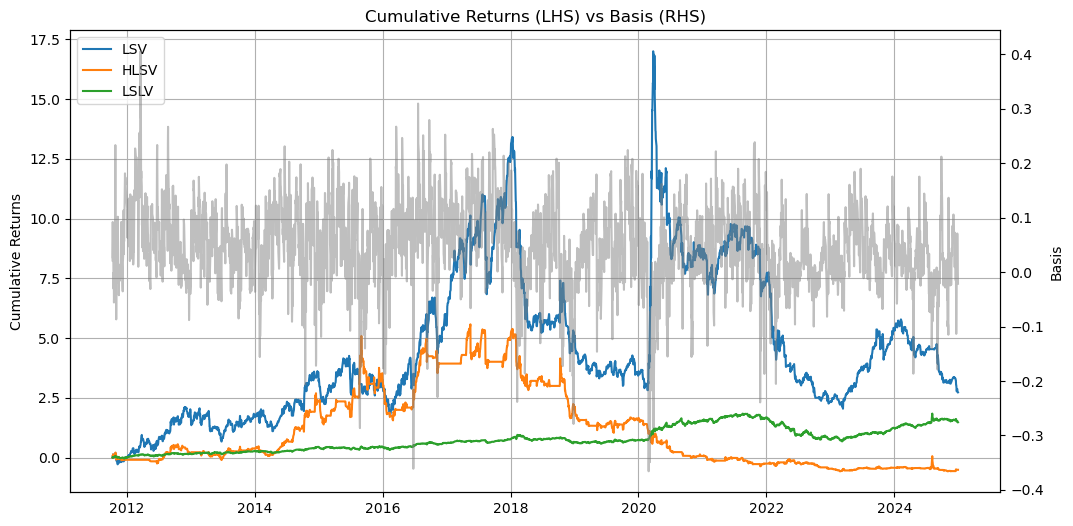

LSV trades: 1045
HLSV trades: 1906
LSLV trades: 4410


In [139]:
plt.figure(figsize=(12,6))

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the three strategies on the left y-axis
for label, res in [('LSV', lsv_res), ('HLSV', hlsv_res), ('LSLV', lslv_res)]:
    ax1.plot(res.index, res['cum_return'], label=label)

ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Cumulative Returns (LHS) vs Basis (RHS)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df.index, df['basis'], color='gray', linestyle='-', label='Basis', alpha=0.5)
ax2.set_ylabel('Basis')

ax1.grid(True)
plt.show()

print('LSV trades:', len(lsv_tr))
print('HLSV trades:', len(hlsv_tr))
print('LSLV trades:', len(lslv_tr))

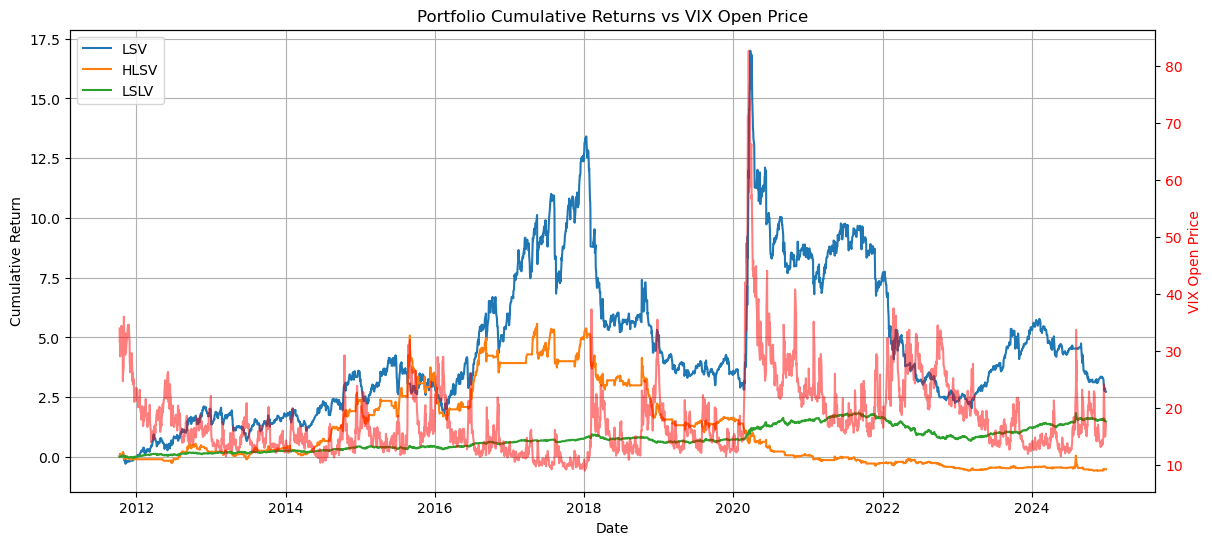

In [87]:
# Combine cumulative returns into a single DataFrame for plotting
combined_df = pd.DataFrame({
    'LSV': lsv_res['cum_return'],
    'HLSV': hlsv_res['cum_return'],
    'LSLV': lslv_res['cum_return'],
    'open_vix': df['open_vix']
}).dropna()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: cumulative returns
ax1.plot(combined_df.index, combined_df['LSV'], label='LSV')
ax1.plot(combined_df.index, combined_df['HLSV'], label='HLSV')
ax1.plot(combined_df.index, combined_df['LSLV'], label='LSLV')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True)

# Right y-axis: VIX Open Price
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['open_vix'], color='red', label='VIX Open Price', alpha=0.5)
ax2.set_ylabel('VIX Open Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and labels
plt.title('Portfolio Cumulative Returns vs VIX Open Price')
ax1.set_xlabel('Date')

plt.show()

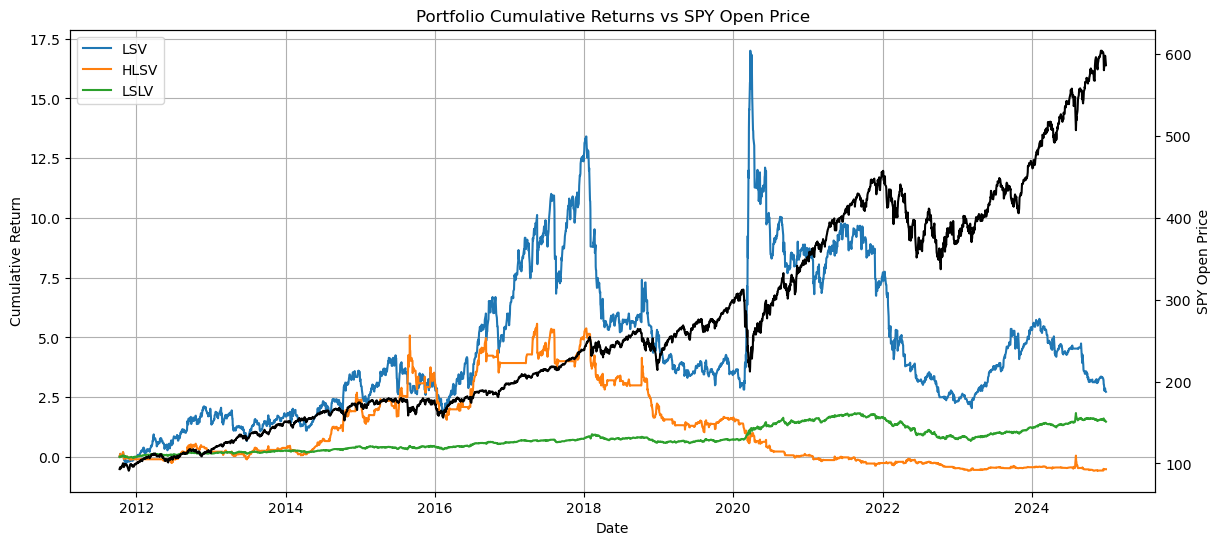

In [148]:
# Combine cumulative returns into a single DataFrame for plotting
combined_df = pd.DataFrame({
    'LSV': lsv_res['cum_return'],
    'HLSV': hlsv_res['cum_return'],
    'LSLV': lslv_res['cum_return'],
    'open_spy': df['open_spy']
}).dropna()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: cumulative returns
ax1.plot(combined_df.index, combined_df['LSV'], label='LSV')
ax1.plot(combined_df.index, combined_df['HLSV'], label='HLSV')
ax1.plot(combined_df.index, combined_df['LSLV'], label='LSLV')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True)

# Right y-axis: VIX Open Price
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['open_spy'], color='black', label='SPY Open Price')
ax2.set_ylabel('SPY Open Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and labels
plt.title('Portfolio Cumulative Returns vs SPY Open Price')
ax1.set_xlabel('Date')

plt.show()

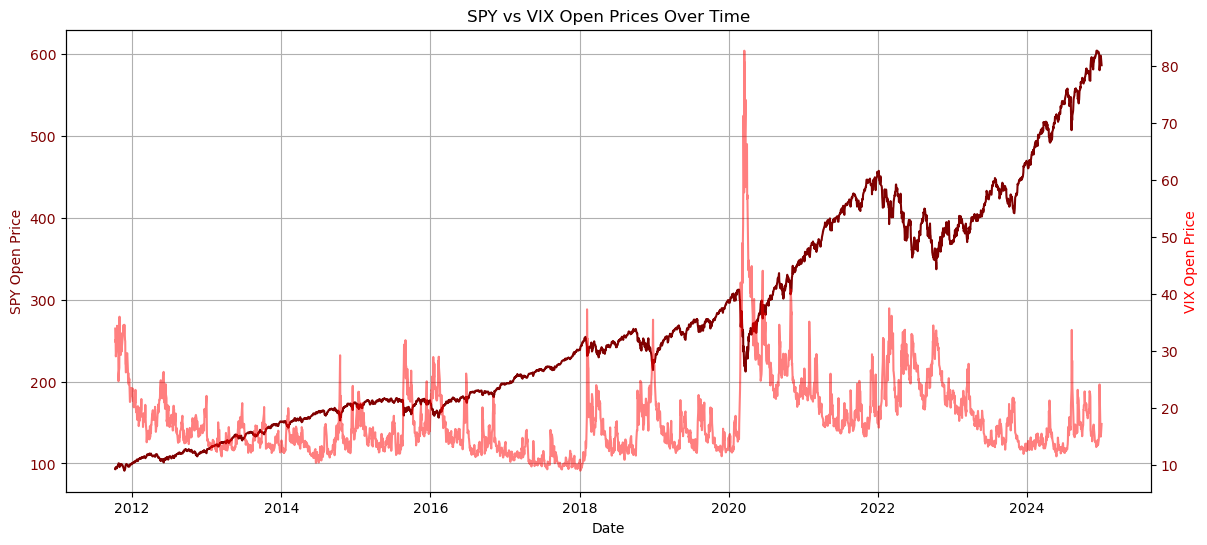

In [89]:
price_df = df[['open_spy', 'open_vix']].dropna()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: SPY Open Price
ax1.plot(price_df.index, price_df['open_spy'], label='SPY Open Price', color='maroon')
ax1.set_ylabel('SPY Open Price', color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')
ax1.set_xlabel('Date')
ax1.grid(True)

# Right y-axis: VIX Open Price
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['open_vix'], label='VIX Open Price', color='red', alpha=0.5)
ax2.set_ylabel('VIX Open Price', color='red')
ax2.tick_params(axis='y', labelcolor='maroon')

# Title
plt.title('SPY vs VIX Open Prices Over Time')

plt.show()

In [90]:
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import pandas_datareader
import datetime

# Defining dates to load data
today = datetime.date.today()
current_quarter = (today.month - 1) // 3 + 1
current_year = today.year
first_month_of_current_quarter = (current_quarter - 1) * 3 + 1
first_day_of_current_quarter = datetime.date(today.year, first_month_of_current_quarter, 1)
last_day_of_previous_quarter = first_day_of_current_quarter - datetime.timedelta(days=1)

# Fama and French 3 Factors and change variables format
FF3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start='2011', end=str(current_year+1))
FF3 = FF3.read()[0]/ 100 # Monthly data
FF3.columns = 'MktRF','SMB','HML','RF'
FF3['Mkt'] = FF3['MktRF'] + FF3['RF']
FF3 = FF3.reset_index().rename(columns={"Date":"date"}).copy()
FF3['date'] = pd.DataFrame(FF3[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
FF3 = FF3[FF3['date'] >= '2011-10-31']
FF3

/var/folders/3q/pn6kdbkn0xgb8djtj70vttcw0000gn/T/ipykernel_26893/308213311.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/ 100 # Monthly data
/var/folders/3q/pn6kdbkn0xgb8djtj70vttcw0000gn/T/ipykernel_26893/308213311.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/ 100 # Monthly data


,date,MktRF,SMB,HML,RF,Mkt
9,2011-10-31,0.1133,0.0305,0.0006,0.0000,0.1133
10,2011-11-30,-0.0027,-0.0018,-0.0052,0.0000,-0.0027
11,2011-12-31,0.0075,-0.0056,0.0154,0.0000,0.0075
12,2012-01-31,0.0505,0.0201,-0.0093,0.0000,0.0505
13,2012-02-29,0.0442,-0.0184,0.0042,0.0000,0.0442
...,...,...,...,...,...,...
166,2024-11-30,0.0649,0.0446,0.0016,0.0040,0.0689
167,2024-12-31,-0.0317,-0.0271,-0.0299,0.0037,-0.0280
168,2025-01-31,0.0280,-0.0197,0.0163,0.0037,0.0317
169,2025-02-28,-0.0244,-0.0579,0.0491,0.0033,-0.0211


In [145]:
def convert_monthly_rf_to_daily(ff3_data, strategy_dates):
    daily_rf = pd.Series(index=strategy_dates, dtype=float)
    
    for date in strategy_dates:
        # Find the corresponding month-end in FF3 data
        month_end = pd.Timestamp(date.year, date.month, 1) + pd.offsets.MonthEnd(0)
        
        # Find the RF rate for this month
        rf_monthly = ff3_data[ff3_data['date'] == month_end]['RF'].iloc[0] if len(ff3_data[ff3_data['date'] == month_end]) > 0 else 0
        
        # Convert monthly to daily (approximate)
        daily_rf[date] = (1 + rf_monthly)**(1/21) - 1  # Assuming ~21 trading days per month
    
    return daily_rf

# Get daily risk-free rates for each strategy
lsv_rf = convert_monthly_rf_to_daily(FF3, lsv_res.index)
hlsv_rf = convert_monthly_rf_to_daily(FF3, hlsv_res.index)
lslv_rf = convert_monthly_rf_to_daily(FF3, lslv_res.index)
spy_rf = convert_monthly_rf_to_daily(FF3, spy_ret.index)

# Recalculate performance metrics with proper risk-free rate adjustment
metrics_corrected = pd.DataFrame(columns=[
    'Total Return', 'Annual Geometric Return','Annualized Vol','Downside Vol',
    'Max Drawdown','Sharpe Ratio','Sortino Ratio','Calmar Ratio'
])

def calculate_metrics(returns, rf_rates, label):
    """Calculate performance metrics with proper risk-free rate adjustment"""
    equity = (1 + returns).cumprod()
    
    # Annual geometric return
    total_ret = equity.iloc[-1] - 1
    n_days = len(equity)
    ann_ret = (1 + total_ret)**(252/n_days) - 1
    
    # Annualized risk-free rate
    ann_rf = (1 + rf_rates.mean())**252 - 1
    
    # Volatility metrics
    ann_vol = returns.std() * np.sqrt(252)
    downside_returns = returns[returns < rf_rates]  # Use RF as threshold for downside
    down_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    
    # Drawdown
    peak = equity.cummax()
    dd = (equity - peak) / peak
    mdd = dd.min()
    
    # Risk-adjusted ratios
    excess_return = ann_ret - ann_rf
    sharpe = excess_return / ann_vol if ann_vol > 0 else np.nan
    
    # For Sortino, use excess returns over RF for downside calculation
    excess_daily_returns = returns - rf_rates
    downside_excess = excess_daily_returns[excess_daily_returns < 0]
    downside_vol_excess = downside_excess.std() * np.sqrt(252) if len(downside_excess) > 0 else 0
    sortino = excess_return / downside_vol_excess if downside_vol_excess > 0 else np.nan
    
    # Calmar ratio
    calmar = excess_return / (-mdd) if mdd < 0 else np.nan
    
    return [total_ret, ann_ret, ann_vol, down_vol, mdd, sharpe, sortino, calmar]

# Calculate metrics for each strategy
for label, res, rf in [('LSV', lsv_res, lsv_rf), ('HLSV', hlsv_res, hlsv_rf), ('LSLV', lslv_res, lslv_rf)]:
    metrics_corrected.loc[label] = calculate_metrics(res['returns'], rf, label)

# Calculate SPY metrics
metrics_corrected.loc['SPY'] = calculate_metrics(spy_ret, spy_rf, 'SPY')

# Format and display results
print("Corrected Performance Metrics (with Risk-Free Rate Adjustment):")
print("=" * 80)

# Create formatted version
metrics_formatted = metrics_corrected.copy()
for col in ['Total Return', 'Annual Geometric Return', 'Annualized Vol', 'Downside Vol', 'Max Drawdown']:
    metrics_formatted[col] = metrics_corrected[col].apply(lambda x: f"{x:.2%}")

for col in ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']:
    metrics_formatted[col] = metrics_corrected[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")

metrics_formatted

Corrected Performance Metrics (with Risk-Free Rate Adjustment):


,Total Return,Annual Geometric Return,Annualized Vol,Downside Vol,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio
LSV,272.62%,10.48%,49.91%,40.05%,-83.10%,0.184,0.230,0.111
HLSV,-51.30%,-5.31%,44.16%,35.23%,-93.54%,-0.149,-0.187,-0.070
LSLV,147.53%,7.11%,13.35%,9.71%,-41.07%,0.437,0.601,0.142
SPY,525.81%,14.91%,16.63%,13.53%,-33.72%,0.820,1.008,0.404


In [140]:
# SPY 3-5% Dip Buying Strategy Backtest
def spy_dip_strategy_backtest(df, dip_threshold=0.10, capital=100000, fee_rate=0.0015, hold_period_days=30):
    
    dates = df.index
    spy_prices_for_threshold = df['open_spy']
    spy_prices = df['close_spy']
    
    lookback_window = 30  # 30 day lookback for peak detection
    rolling_max = spy_prices_for_threshold.rolling(window=lookback_window, min_periods=1).max()
    drawdown = (spy_prices_for_threshold - rolling_max) / rolling_max
    
    cash = capital
    position_size = 0.0
    entry_date = None
    exit_date = None
    
    cash_hist = []
    position_hist = []
    portfolio_hist = []
    signal_hist = []
    drawdown_hist = []
    
    trades = []
    
    for i, date in enumerate(dates):
        
        current_price = spy_prices.loc[date]
        current_drawdown = drawdown.loc[date]
        
        # Check for buy signal: drawdown >= threshold and not currently holding
        buy_signal = (current_drawdown <= -dip_threshold) and (position_size == 0)
        
        # Check for sell signal based on holding period
        sell_signal = False
        if position_size > 0 and entry_date is not None:
            if hold_period_days is not None:
                days_held = (date - entry_date).days
                sell_signal = days_held >= hold_period_days
        
        # Execute buy order
        if buy_signal:
            # Buy as much SPY as possible with available cash
            shares_to_buy = cash / (current_price * (1 + fee_rate))
            if shares_to_buy > 0:
                fee = shares_to_buy * current_price * fee_rate
                total_cost = shares_to_buy * current_price + fee
                
                if total_cost <= cash:
                    position_size = shares_to_buy
                    cash -= total_cost
                    entry_date = date
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'fee': fee,
                        'drawdown_at_entry': current_drawdown
                    })
        
        # Execute sell order
        elif sell_signal and position_size > 0:
            fee = position_size * current_price * fee_rate
            proceeds = position_size * current_price - fee
            cash += proceeds
            
            trades.append({
                'date': date,
                'action': 'SELL',
                'price': current_price,
                'shares': position_size,
                'fee': fee,
                'days_held': (date - entry_date).days if entry_date else 0
            })
            
            position_size = 0.0
            entry_date = None
        
        # Record daily values
        position_value = position_size * current_price
        portfolio_value = cash + position_value
        
        cash_hist.append(cash)
        position_hist.append(position_value)
        portfolio_hist.append(portfolio_value)
        signal_hist.append('BUY' if buy_signal else ('SELL' if sell_signal else 'HOLD'))
        drawdown_hist.append(current_drawdown)
    
    results_df = pd.DataFrame({
        'cash': cash_hist,
        'position_value': position_hist,
        'portfolio': portfolio_hist,
        'signal': signal_hist,
        'spy_price': spy_prices.values,
        'drawdown_from_peak': drawdown_hist,
        'rolling_peak': rolling_max.values
    }, index=dates)
    
    results_df['returns'] = results_df['portfolio'].pct_change().fillna(0)
    results_df['cum_return'] = (1 + results_df['returns']).cumprod() - 1
    
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df.set_index('date', inplace=True)
    
    return results_df, trades_df

def analyze_dip_strategy_performance(results_df, trades_df, strategy_name="SPY Dip Strategy"):
    """Analyze and display performance metrics for the dip buying strategy"""
    
    # Basic performance metrics
    total_return = results_df['cum_return'].iloc[-1]
    
    # Annualized metrics
    n_days = len(results_df)
    ann_return = (1 + total_return)**(252/n_days) - 1
    ann_vol = results_df['returns'].std() * np.sqrt(252)
    
    # Drawdown analysis
    equity_curve = 1 + results_df['cum_return']
    peak = equity_curve.cummax()
    portfolio_dd = (equity_curve - peak) / peak
    max_dd = portfolio_dd.min()
    
    # Risk metrics
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    downside_vol = results_df['returns'][results_df['returns'] < 0].std() * np.sqrt(252)
    sortino = ann_return / downside_vol if downside_vol > 0 else np.nan
    calmar = ann_return / (-max_dd) if max_dd < 0 else np.nan
    
    # Trade analysis
    if not trades_df.empty:
        buy_trades = trades_df[trades_df['action'] == 'BUY']
        sell_trades = trades_df[trades_df['action'] == 'SELL']
        
        n_trades = len(buy_trades)
        avg_drawdown_at_entry = buy_trades['drawdown_at_entry'].mean() if len(buy_trades) > 0 else 0
        
        if len(sell_trades) > 0:
            avg_hold_period = sell_trades['days_held'].mean()
        else:
            avg_hold_period = np.nan
    else:
        n_trades = 0
        avg_drawdown_at_entry = 0
        avg_hold_period = np.nan
    
    # Create performance summary
    performance_summary = {
        'Strategy': strategy_name,
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{ann_return:.2%}",
        'Annualized Volatility': f"{ann_vol:.2%}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Sortino Ratio': f"{sortino:.3f}",
        'Calmar Ratio': f"{calmar:.3f}",
        'Number of Trades': n_trades,
        'Avg Drawdown at Entry': f"{avg_drawdown_at_entry:.2%}",
        'Avg Hold Period (Days)': f"{avg_hold_period:.1f}" if not pd.isna(avg_hold_period) else "N/A"
    }
    
    return performance_summary

# Run the SPY dip buying strategy
print("Running SPY 10% Dip Buying Strategy Backtest...")
print("=" * 60)

# Test different variations of the strategy
strategies_to_test = [
    {'name': 'SPY_Dip_10%_Hold_30d', 'dip_threshold': 0.10, 'hold_period': 30},
    {'name': 'SPY_Dip_5%_Hold_60d', 'dip_threshold': 0.05, 'hold_period': 60},
    {'name': 'SPY_Dip_5%_Hold_30d', 'dip_threshold': 0.05, 'hold_period': 30},
    {'name': 'SPY_Dip_3%_Hold_60d', 'dip_threshold': 0.03, 'hold_period': 60},
]

strategy_results = {}
all_performance = []

for strategy_config in strategies_to_test:
    name = strategy_config['name']
    dip_thresh = strategy_config['dip_threshold']
    hold_days = strategy_config['hold_period']
    
    # Run backtest
    results, trades = spy_dip_strategy_backtest(
        df, 
        dip_threshold=dip_thresh, 
        hold_period_days=hold_days
    )
    
    # Analyze performance
    performance = analyze_dip_strategy_performance(results, trades, name)
    
    strategy_results[name] = {'results': results, 'trades': trades, 'performance': performance}
    all_performance.append(performance)
    
    print(f"\n{name}:")
    print("-" * 40)
    for key, value in performance.items():
        if key != 'Strategy':
            print(f"{key}: {value}")

# Create comparison DataFrame
print("\n\nStrategy Comparison:")
print("=" * 80)
comparison_df = pd.DataFrame(all_performance).set_index('Strategy')
comparison_df

# Show some sample trades from the main strategy
main_strategy = 'SPY_Dip_5%_Hold_60d'
sample_trades = strategy_results[main_strategy]['trades']

# Calculate comparison with Buy & Hold SPY
spy_buy_hold_return = (df['close_spy'].iloc[-1] / df['close_spy'].iloc[0]) - 1
spy_buy_hold_ann = (1 + spy_buy_hold_return)**(252/len(df)) - 1

print(f"\n\nComparison with SPY Buy & Hold:")
print("=" * 40)
print(f"SPY Buy & Hold Total Return: {spy_buy_hold_return:.2%}")
print(f"SPY Buy & Hold Annualized: {spy_buy_hold_ann:.2%}")

# Show which strategy performed best
best_strategy = max(all_performance, key=lambda x: float(x['Total Return'].strip('%'))/100)
print(f"\nBest Performing Dip Strategy: {best_strategy['Strategy']}")
print(f"Total Return: {best_strategy['Total Return']}")

comparison_df

Running SPY 10% Dip Buying Strategy Backtest...

SPY_Dip_10%_Hold_30d:
----------------------------------------
Total Return: 15.02%
Annualized Return: 1.07%
Annualized Volatility: 9.66%
Max Drawdown: -28.32%
Sharpe Ratio: 0.110
Sortino Ratio: 0.038
Calmar Ratio: 0.038
Number of Trades: 10
Avg Drawdown at Entry: -12.26%
Avg Hold Period (Days): 30.9

SPY_Dip_5%_Hold_60d:
----------------------------------------
Total Return: 138.32%
Annualized Return: 6.80%
Annualized Volatility: 13.17%
Max Drawdown: -29.86%
Sharpe Ratio: 0.516
Sortino Ratio: 0.377
Calmar Ratio: 0.228
Number of Trades: 27
Avg Drawdown at Entry: -5.99%
Avg Hold Period (Days): 60.6

SPY_Dip_5%_Hold_30d:
----------------------------------------
Total Return: 131.38%
Annualized Return: 6.56%
Annualized Volatility: 12.53%
Max Drawdown: -28.32%
Sharpe Ratio: 0.524
Sortino Ratio: 0.332
Calmar Ratio: 0.232
Number of Trades: 39
Avg Drawdown at Entry: -7.03%
Avg Hold Period (Days): 30.7

SPY_Dip_3%_Hold_60d:
---------------------

,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Number of Trades,Avg Drawdown at Entry,Avg Hold Period (Days)
Strategy,,,,,,,,,,
SPY_Dip_10%_Hold_30d,15.02%,1.07%,9.66%,-28.32%,0.110,0.038,0.038,10,-12.26%,30.9
SPY_Dip_5%_Hold_60d,138.32%,6.80%,13.17%,-29.86%,0.516,0.377,0.228,27,-5.99%,60.6
SPY_Dip_5%_Hold_30d,131.38%,6.56%,12.53%,-28.32%,0.524,0.332,0.232,39,-7.03%,30.7
SPY_Dip_3%_Hold_60d,238.81%,9.69%,14.84%,-31.00%,0.653,0.633,0.312,47,-4.05%,61.0


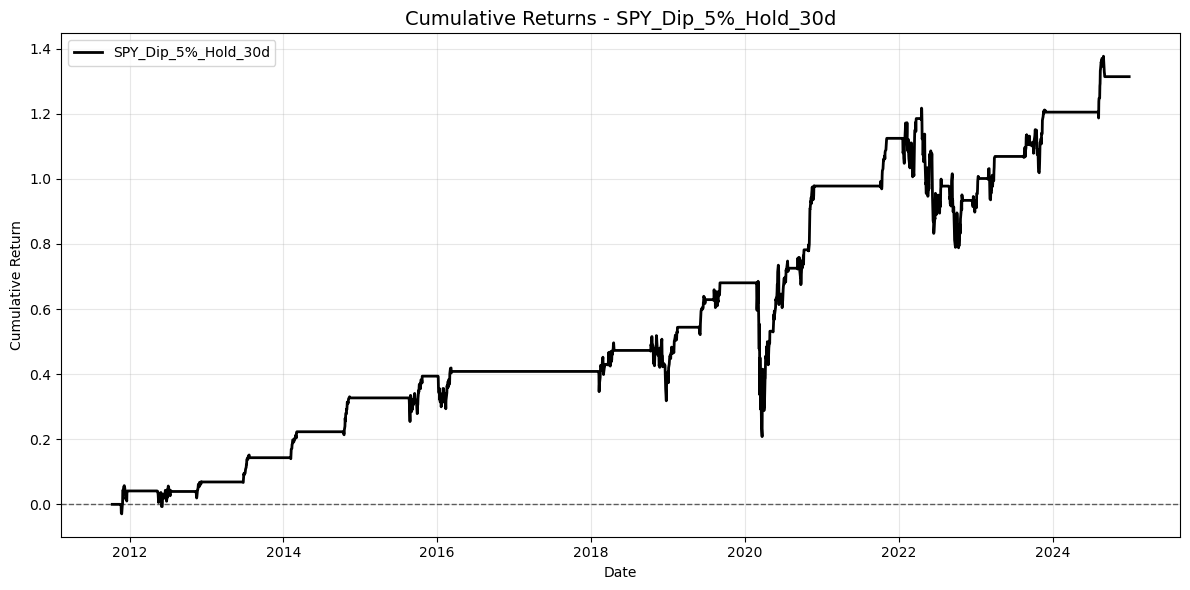

In [146]:
# Get the strategy results
strategy_name = 'SPY_Dip_5%_Hold_30d'
results_df = strategy_results[strategy_name]['results']

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['cum_return'], label=strategy_name, color='black', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.title(f'Cumulative Returns - {strategy_name}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


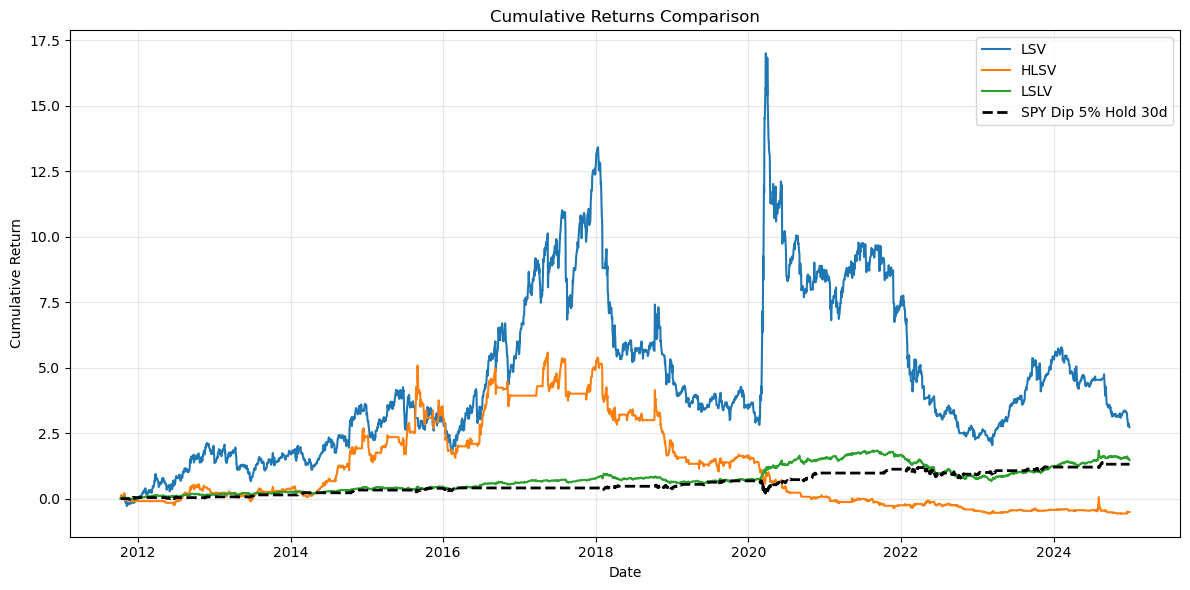

In [143]:
spy_dip_results = strategy_results['SPY_Dip_5%_Hold_30d']['results']

# Plot all strategies together
plt.figure(figsize=(12, 6))
for label, res in [('LSV', lsv_res), ('HLSV', hlsv_res), ('LSLV', lslv_res)]:
    plt.plot(res.index, res['cum_return'], label=label)

# Add SPY Dip strategy
plt.plot(spy_dip_results.index, spy_dip_results['cum_return'], label='SPY Dip 5% Hold 30d', color='black', linestyle='--', linewidth=2)

plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [117]:
# Factor Model Analysis for VIX Trading Strategies
# This code performs CAPM and Fama-French 3-factor analysis on LSV, HLSV, and LSLV strategies

from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from datetime import datetime

def align_returns_with_factors(strategy_returns, ff3_data):
    """
    Align daily strategy returns with monthly Fama-French factors
    Convert strategy returns to monthly frequency to match FF3 data
    """
    # Convert daily returns to monthly
    monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    
    # Align dates - FF3 uses month-end dates
    monthly_returns.index = monthly_returns.index + pd.offsets.MonthEnd(0)
    
    # Merge with FF3 factors
    merged_data = pd.merge(
        monthly_returns.to_frame('strategy_return'),
        ff3_data[['date', 'MktRF', 'SMB', 'HML', 'RF']],
        left_index=True,
        right_on='date',
        how='inner'
    ).set_index('date')
    
    return merged_data

def capm_analysis(excess_returns, market_excess_returns):
    """
    Perform CAPM analysis
    Returns: alpha, beta, r_squared, t_stats, p_values
    """
    # Ensure we have clean data
    valid_data = pd.DataFrame({
        'strategy': excess_returns,
        'market': market_excess_returns
    }).dropna()
    
    if len(valid_data) < 10:  # Need minimum observations
        return None, None, None, None, None
    
    X = valid_data['market'].values.reshape(-1, 1)
    y = valid_data['strategy'].values
    
    # Fit regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate statistics
    alpha = model.intercept_
    beta = model.coef_[0]
    
    # R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Standard errors and t-statistics
    n = len(valid_data)
    mse = ss_res / (n - 2)
    
    # Standard error of alpha
    x_mean = np.mean(valid_data['market'])
    se_alpha = np.sqrt(mse * (1/n + x_mean**2 / np.sum((valid_data['market'] - x_mean)**2)))
    
    # Standard error of beta
    se_beta = np.sqrt(mse / np.sum((valid_data['market'] - x_mean)**2))
    
    # t-statistics
    t_alpha = alpha / se_alpha
    t_beta = beta / se_beta
    
    # p-values (two-tailed)
    p_alpha = 2 * (1 - stats.t.cdf(abs(t_alpha), n - 2))
    p_beta = 2 * (1 - stats.t.cdf(abs(t_beta), n - 2))
    
    return alpha, beta, r_squared, (t_alpha, t_beta), (p_alpha, p_beta)

def fama_french_3factor_analysis(excess_returns, ff3_factors):
    """
    Perform Fama-French 3-factor analysis
    Returns: alpha, betas, r_squared, t_stats, p_values
    """
    # Prepare data
    valid_data = pd.DataFrame({
        'strategy': excess_returns,
        'MktRF': ff3_factors['MktRF'],
        'SMB': ff3_factors['SMB'],
        'HML': ff3_factors['HML']
    }).dropna()
    
    if len(valid_data) < 15:  # Need minimum observations for 3-factor model
        return None, None, None, None, None
    
    X = valid_data[['MktRF', 'SMB', 'HML']].values
    y = valid_data['strategy'].values
    
    # Fit regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate statistics
    alpha = model.intercept_
    betas = model.coef_
    
    # R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Standard errors using matrix algebra
    n, k = X.shape
    mse = ss_res / (n - k - 1)
    
    # Add intercept column for full coefficient matrix
    X_with_intercept = np.column_stack([np.ones(n), X])
    
    try:
        # Covariance matrix of coefficients
        cov_matrix = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        se_coeffs = np.sqrt(np.diag(cov_matrix))
        
        # t-statistics
        coeffs = np.array([alpha] + list(betas))
        t_stats = coeffs / se_coeffs
        
        # p-values (two-tailed)
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k - 1))
        
        return alpha, betas, r_squared, t_stats, p_values
    except np.linalg.LinAlgError:
        # In case of singular matrix
        return alpha, betas, r_squared, None, None

def perform_factor_analysis(strategy_results, ff3_data, strategy_name):
    """
    Perform comprehensive factor analysis for a strategy
    """
    print(f"\n{'='*60}")
    print(f"FACTOR ANALYSIS: {strategy_name}")
    print(f"{'='*60}")
    
    # Align returns with factors
    aligned_data = align_returns_with_factors(strategy_results['returns'], ff3_data)
    
    if len(aligned_data) < 10:
        print(f"Insufficient data for {strategy_name} analysis")
        return None
    
    print(f"Analysis period: {aligned_data.index[0].strftime('%Y-%m')} to {aligned_data.index[-1].strftime('%Y-%m')}")
    print(f"Number of monthly observations: {len(aligned_data)}")
    
    # Calculate excess returns
    strategy_excess = aligned_data['strategy_return'] - aligned_data['RF']
    
    # CAPM Analysis
    print(f"\n{'-'*40}")
    print("CAPM ANALYSIS")
    print(f"{'-'*40}")
    
    alpha_capm, beta_capm, r2_capm, t_stats_capm, p_vals_capm = capm_analysis(
        strategy_excess, aligned_data['MktRF']
    )
    
    if alpha_capm is not None:
        print(f"Alpha (monthly):     {alpha_capm:8.4f} ({alpha_capm*12:7.2%} annualized)")
        print(f"  t-statistic:       {t_stats_capm[0]:8.3f}")
        print(f"  p-value:           {p_vals_capm[0]:8.4f} {'***' if p_vals_capm[0] < 0.01 else '**' if p_vals_capm[0] < 0.05 else '*' if p_vals_capm[0] < 0.1 else ''}")
        print(f"Beta (Market):       {beta_capm:8.4f}")
        print(f"  t-statistic:       {t_stats_capm[1]:8.3f}")
        print(f"  p-value:           {p_vals_capm[1]:8.4f} {'***' if p_vals_capm[1] < 0.01 else '**' if p_vals_capm[1] < 0.05 else '*' if p_vals_capm[1] < 0.1 else ''}")
        print(f"R-squared:           {r2_capm:8.4f} ({r2_capm:6.1%})")
    
    # Fama-French 3-Factor Analysis
    print(f"\n{'-'*40}")
    print("FAMA-FRENCH 3-FACTOR ANALYSIS")
    print(f"{'-'*40}")
    
    alpha_ff3, betas_ff3, r2_ff3, t_stats_ff3, p_vals_ff3 = fama_french_3factor_analysis(
        strategy_excess, aligned_data
    )
    
    if alpha_ff3 is not None:
        print(f"Alpha (monthly):     {alpha_ff3:8.4f} ({alpha_ff3*12:7.2%} annualized)")
        if t_stats_ff3 is not None:
            print(f"  t-statistic:       {t_stats_ff3[0]:8.3f}")
            print(f"  p-value:           {p_vals_ff3[0]:8.4f} {'***' if p_vals_ff3[0] < 0.01 else '**' if p_vals_ff3[0] < 0.05 else '*' if p_vals_ff3[0] < 0.1 else ''}")
        
        print(f"Beta (Market):       {betas_ff3[0]:8.4f}")
        if t_stats_ff3 is not None:
            print(f"  t-statistic:       {t_stats_ff3[1]:8.3f}")
            print(f"  p-value:           {p_vals_ff3[1]:8.4f} {'***' if p_vals_ff3[1] < 0.01 else '**' if p_vals_ff3[1] < 0.05 else '*' if p_vals_ff3[1] < 0.1 else ''}")
        
        print(f"Beta (SMB):          {betas_ff3[1]:8.4f}")
        if t_stats_ff3 is not None:
            print(f"  t-statistic:       {t_stats_ff3[2]:8.3f}")
            print(f"  p-value:           {p_vals_ff3[2]:8.4f} {'***' if p_vals_ff3[2] < 0.01 else '**' if p_vals_ff3[2] < 0.05 else '*' if p_vals_ff3[2] < 0.1 else ''}")
        
        print(f"Beta (HML):          {betas_ff3[2]:8.4f}")
        if t_stats_ff3 is not None:
            print(f"  t-statistic:       {t_stats_ff3[3]:8.3f}")
            print(f"  p-value:           {p_vals_ff3[3]:8.4f} {'***' if p_vals_ff3[3] < 0.01 else '**' if p_vals_ff3[3] < 0.05 else '*' if p_vals_ff3[3] < 0.1 else ''}")
        
        print(f"R-squared:           {r2_ff3:8.4f} ({r2_ff3:6.1%})")
        
        # Model comparison
        if r2_capm is not None:
            r2_improvement = r2_ff3 - r2_capm
            print(f"R² improvement:      {r2_improvement:8.4f} ({r2_improvement:6.1%})")
    
    # Return results for summary table
    results = {
        'CAPM_Alpha': alpha_capm * 12 if alpha_capm else np.nan,  # Annualized
        'CAPM_Beta': beta_capm if beta_capm else np.nan,
        'CAPM_R2': r2_capm if r2_capm else np.nan,
        'FF3_Alpha': alpha_ff3 * 12 if alpha_ff3 else np.nan,  # Annualized
        'FF3_Beta_Market': betas_ff3[0] if betas_ff3 is not None else np.nan,
        'FF3_Beta_SMB': betas_ff3[1] if betas_ff3 is not None else np.nan,
        'FF3_Beta_HML': betas_ff3[2] if betas_ff3 is not None else np.nan,
        'FF3_R2': r2_ff3 if r2_ff3 else np.nan,
        'Alpha_p_value': p_vals_ff3[0] if p_vals_ff3 is not None else np.nan
    }
    
    return results, aligned_data

# Run factor analysis for all strategies
print("FACTOR MODEL ANALYSIS FOR VIX TRADING STRATEGIES")
print("="*80)

factor_results = {}
aligned_data_dict = {}

# Analyze each strategy
for strategy_name, strategy_result in [
    ('LSV', lsv_res), 
    ('HLSV', hlsv_res), 
    ('LSLV', lslv_res)
]:
    results, aligned_data = perform_factor_analysis(strategy_result, FF3, strategy_name)
    factor_results[strategy_name] = results
    aligned_data_dict[strategy_name] = aligned_data

# Create summary table
print(f"\n{'='*80}")
print("SUMMARY TABLE: FACTOR MODEL RESULTS")
print(f"{'='*80}")

summary_df = pd.DataFrame(factor_results).T

# Format the summary table
summary_formatted = summary_df.copy()
for col in ['CAPM_Alpha', 'FF3_Alpha']:
    summary_formatted[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if not pd.isna(x) else "N/A")

for col in ['CAPM_Beta', 'FF3_Beta_Market', 'FF3_Beta_SMB', 'FF3_Beta_HML']:
    summary_formatted[col] = summary_df[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")

for col in ['CAPM_R2', 'FF3_R2']:
    summary_formatted[col] = summary_df[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")

print(summary_formatted)

# Significance legend
print(f"\n{'-'*40}")
print("SIGNIFICANCE LEVELS")
print(f"{'-'*40}")
print("*** p < 0.01 (highly significant)")
print("**  p < 0.05 (significant)")
print("*   p < 0.10 (marginally significant)")

# Interpretation
print(f"\n{'='*80}")
print("INTERPRETATION")
print(f"{'='*80}")

for strategy in factor_results.keys():
    results = factor_results[strategy]
    print(f"\n{strategy} Strategy:")
    print(f"{'-'*20}")
    
    # Alpha interpretation
    capm_alpha = results['CAPM_Alpha']
    ff3_alpha = results['FF3_Alpha']
    
    if not pd.isna(capm_alpha):
        print(f"• CAPM Alpha: {capm_alpha:.1%} suggests {'positive' if capm_alpha > 0 else 'negative'} risk-adjusted returns")
    
    if not pd.isna(ff3_alpha):
        alpha_significance = "significant" if results['Alpha_p_value'] < 0.05 else "not significant"
        print(f"• FF3 Alpha: {ff3_alpha:.1%} is {alpha_significance}")
    
    # Beta interpretation
    market_beta = results['FF3_Beta_Market'] if not pd.isna(results['FF3_Beta_Market']) else results['CAPM_Beta']
    if not pd.isna(market_beta):
        if abs(market_beta) < 0.1:
            market_exposure = "very low"
        elif abs(market_beta) < 0.5:
            market_exposure = "low"
        elif abs(market_beta) < 1.5:
            market_exposure = "moderate"
        else:
            market_exposure = "high"
        
        direction = "positive" if market_beta > 0 else "negative"
        print(f"• Market exposure: {direction} {market_exposure} ({market_beta:.2f})")
    
    # Factor exposures
    smb_beta = results['FF3_Beta_SMB']
    hml_beta = results['FF3_Beta_HML']
    
    if not pd.isna(smb_beta):
        size_bias = "small-cap" if smb_beta > 0.1 else "large-cap" if smb_beta < -0.1 else "size-neutral"
        print(f"• Size bias: {size_bias} ({smb_beta:.2f})")
    
    if not pd.isna(hml_beta):
        value_bias = "value" if hml_beta > 0.1 else "growth" if hml_beta < -0.1 else "style-neutral"
        print(f"• Value bias: {value_bias} ({hml_beta:.2f})")

FACTOR MODEL ANALYSIS FOR VIX TRADING STRATEGIES

FACTOR ANALYSIS: LSV
Analysis period: 2011-10 to 2024-12
Number of monthly observations: 159

----------------------------------------
CAPM ANALYSIS
----------------------------------------
Alpha (monthly):       0.0241 ( 28.91% annualized)
  t-statistic:          1.290
  p-value:             0.1988 
Beta (Market):        -0.0966
  t-statistic:         -0.229
  p-value:             0.8192 
R-squared:             0.0003 (  0.0%)

----------------------------------------
FAMA-FRENCH 3-FACTOR ANALYSIS
----------------------------------------
Alpha (monthly):       0.0210 ( 25.19% annualized)
  t-statistic:          1.161
  p-value:             0.2474 
Beta (Market):         0.0177
  t-statistic:          0.041
  p-value:             0.9670 
Beta (SMB):           -0.2684
  t-statistic:         -0.383
  p-value:             0.7025 
Beta (HML):           -1.9611
  t-statistic:         -3.811
  p-value:             0.0002 ***
R-squared:       